## use it in PyTorch

In [1]:
# data_dir = "data"
data_dir = "lexicalized_data"

from dataset import syntax_token_type
syntax_vocabulary, blacklist = syntax_token_type(data_dir)

encountering ambiguous tag at lexicalized_data/sw2260#s283_500/syntax.txt, break-tied
encountering type II typo at lexicalized_data/sw2249#s67_500/syntax.txt, blacklisted
encountering type II typo at lexicalized_data/sw2789#s226_500/syntax.txt, blacklisted
encountering type II typo at lexicalized_data/sw2229#s140_500/syntax.txt, blacklisted
encountering type II typo at lexicalized_data/sw2589#s154_500/syntax.txt, blacklisted
encountering type II typo at lexicalized_data/sw2067#s50_500/syntax.txt, blacklisted
encountering type II typo at lexicalized_data/sw2154#s6_500/syntax.txt, blacklisted
encountering ambiguous tag at lexicalized_data/sw2015#s53_500/syntax.txt, break-tied
encountering type II typo at lexicalized_data/sw2079#s10_500/syntax.txt, blacklisted
encountering type II typo at lexicalized_data/sw2434#s87_500/syntax.txt, blacklisted
encountering a weird semicolon at lexicalized_data/sw3049#s167_500/syntax.txt, blacklisted
encountering type II typo at lexicalized_data/sw2229#s23

In [2]:
if data_dir == "data":
    print(syntax_vocabulary)
print(len(syntax_vocabulary))
print(blacklist)

13815
{'lexicalized_data/sw2229#s140_500', 'lexicalized_data/sw2249#s148_500', 'lexicalized_data/sw2154#s93_500', 'lexicalized_data/sw2067#s50_500', 'lexicalized_data/sw2249#s194_500', 'lexicalized_data/sw2078#s154_500', 'lexicalized_data/sw2784#s85_500', 'lexicalized_data/sw3049#s167_500', 'lexicalized_data/sw2079#s10_500', 'lexicalized_data/sw2641#s78_500', 'lexicalized_data/sw2154#s6_500', 'lexicalized_data/sw2789#s226_500', 'lexicalized_data/sw2719#s157_500', 'lexicalized_data/sw2434#s87_500', 'lexicalized_data/sw2229#s91_500', 'lexicalized_data/sw2249#s149_500', 'lexicalized_data/sw3294#s121_500', 'lexicalized_data/sw3561#s32_500', 'lexicalized_data/sw2249#s67_500', 'lexicalized_data/sw2589#s154_500', 'lexicalized_data/sw2229#s232_500'}


In [3]:
from dataset import SpeechSyntax, Phase, get_dataloader

dataloader = get_dataloader(
    root=data_dir, phase=Phase.TRAIN, syntax_vocabulary=syntax_vocabulary, blacklist=blacklist,
    batch_size=4, shuffle=True, num_workers=2
)

This is only for demo. You probably will never call ```pad_packed_sequence``` explicitly, which wastes a good deal of memory

In [4]:
from torch.nn.utils.rnn import PackedSequence, pad_packed_sequence
from dataset import restore_order
import numpy as np

for speech, syntax in dataloader:
    speech, inv_perm_index_speech = speech
    syntax, inv_perm_index_syntax = syntax
    assert type(speech) == PackedSequence
    assert type(syntax) == PackedSequence  # PackedSequence can be fed into a RNN directly
    
    # okay let's pretend there's a RNN and we are through it
    
    unpacked_speech, unpacked_speech_len = pad_packed_sequence(speech, batch_first=True)
    # restore order
    unpacked_speech = restore_order(unpacked_speech, inv_perm_index_speech)
    unpacked_speech_len = np.take(unpacked_speech_len, inv_perm_index_speech)
    print("speech batch")
    print(unpacked_speech.shape)
    print(unpacked_speech_len)
    
    unpacked_syntax, unpacked_syntax_len = pad_packed_sequence(syntax, batch_first=True)
    # restore order
    unpacked_syntax = restore_order(unpacked_syntax, inv_perm_index_syntax)
    unpacked_syntax_len = np.take(unpacked_syntax_len, inv_perm_index_syntax)
    print("syntax batch")
    print(unpacked_syntax.shape)
    print(unpacked_syntax_len)
    
    print("It's only a demo, people.")
    break

speech batch
torch.Size([4, 35360])
tensor([33280, 20160, 35360, 31054])
syntax batch
torch.Size([4, 232])
tensor([196, 180, 232, 192])
It's only a demo, people.


In [5]:
import IPython
import IPython.display as ipd
from nltk.tree import Tree


def display_speech(unpacked_speech, unpacked_speech_len):
    auds = []
    for s, l in zip(unpacked_speech, unpacked_speech_len):
        speech = s[:l].numpy()
        auds.append(ipd.Audio(speech, rate=8000))
    return auds


def display_syntax(unpacked_syntax, unpacked_syntax_len):
    for s, l in zip(unpacked_syntax, unpacked_syntax_len):
        indices = s[:l].numpy()
        tokens = []
        for i in indices:  # turn indices into human-readable strings
            for k, v in syntax_vocabulary.items():
                if v == i:
                    tokens.append(k)
                    break
        syntax = "".join(tokens)
        print(syntax)
        tree = Tree.fromstring(syntax, brackets="[]")
        IPython.core.display.display(tree)


[S[CC[and]][NP[PRP[they]]][ADVP[RB[also]]][VP[VBD[had]][S[NP[NNS[children]]][VP[VP[VBG[calling]][PRT[IN[in]]][ADVP[JJ[live]]][PP[IN[from]][PP[RB[all]][IN[over]][NP[DT[the]][NN[country]]]]]][CC[and]][VP[VBG[asking]][NP[NNS[questions]]]]]]][.[.]]]


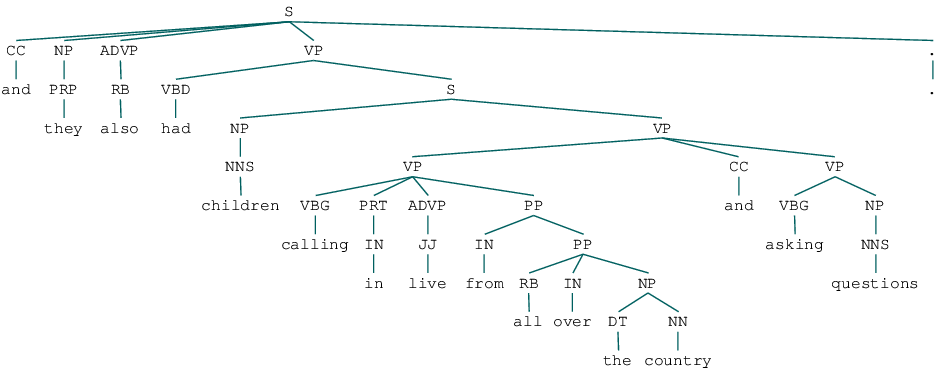

[S[S[NP[DT[that]]][VP[BES['s]][SBAR[WHNP[WP[what]]][S[NP[PRP[we]]][VP[MD['d]][ADVP[RB[rather]]][VP[VB[have]][NP[TRACE[<TRACE>]]]]]]]]][VP[VBZ[is]][ADVP[RB[just]]][NP[NP[DT[a]][NN[pet]]][CONJP[IN[instead]][IN[of]]]]]]


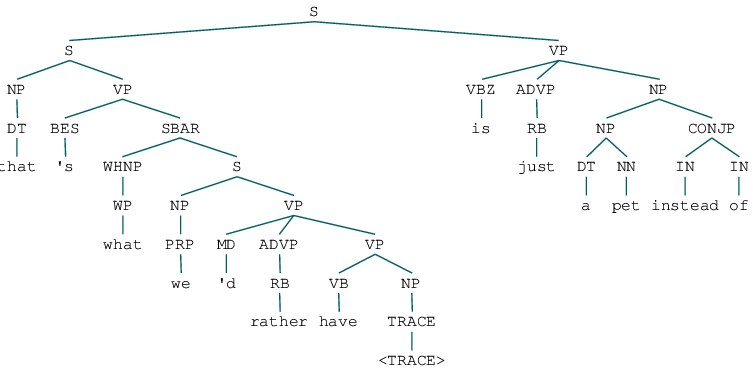

[S[CONJP[CC[And]][RB[so]]][NP[PRP[we]]][VP[MD[would]][VP[VB[drive]][ADVP[IN[up]]][S[NP[TRACE[<TRACE>]]][VP[TO[to]][VP[VB[see]][NP[DT[that]]]]]][SBAR[EDITED[EDITED[WHADVP[WRB[when]]]][WHADVP[WRB[w-]]]][WHADVP[WRB[whenever]]][S[NP[PRP[it]]][VP[VBD[was]][ADVP[RB[reasonably]][RB[close]]][ADVP[TRACE[<TRACE>]]]]]]]]]


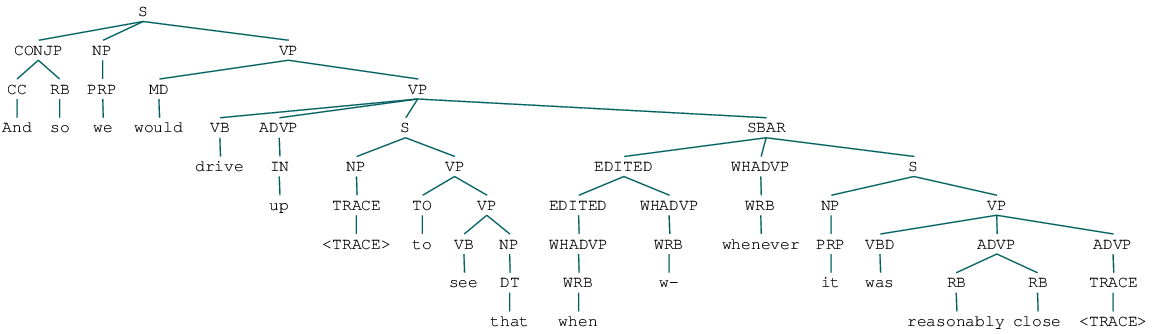

[S[NP[PRP[I]]][VP[MD['d]][VP[VB[have]][NP[ADJP[NP[DT[a]][NN[lot]]][JJR[more]]][NNS[cats]]][SBAR[IN[if]][S[NP[PRP$[my]][NN[boyfriend]]][VP[MD[would]][EDITED[VP[VB[let]][NP[PRP[u-]]]]][VP[VB[let]][NP[PRP[me]]]]]]]]][.[.]]]


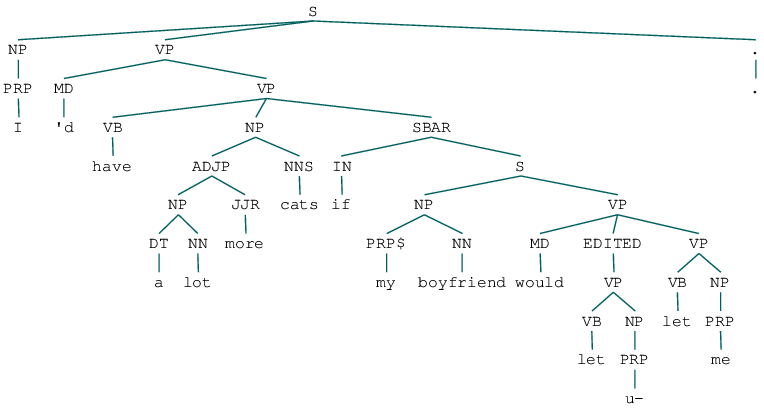

In [6]:
auds = display_speech(unpacked_speech, unpacked_speech_len)
display_syntax(unpacked_syntax, unpacked_syntax_len)

In [7]:
auds[0]

In [8]:
auds[1]

In [9]:
auds[2]

In [10]:
auds[3]